# Section 1: Exploring Data For Creating Evaluation

In [2]:
import pandas as pd
from fastparquet import ParquetFile
import duckdb

In [3]:
""" Initial Load Of Datasets We're Using """
autographs : pd.DataFrame = ParquetFile("datasets/autographs.parquet").to_pandas()
graffitis : pd.DataFrame = ParquetFile("datasets/graffiti.parquet").to_pandas()
stickers : pd.DataFrame = ParquetFile("datasets/sticker.parquet").to_pandas()
matches : pd.DataFrame = ParquetFile("datasets/matches_edit.parquet").to_pandas()
placements : pd.DataFrame = ParquetFile("datasets/placements.parquet").to_pandas()

In [4]:
""" Getting Tournament With Teams """
query = f"""
    WITH
        dates AS (
            SELECT 
                matches.event,
                MIN(date) AS start_date,
                MAX(date) AS end_date,
            FROM matches
            JOIN placements ON
                matches.event = placements.event
            GROUP BY
                matches.event
        )
    SELECT dates.*, team
    FROM dates
    JOIN placements ON
        dates.event = placements.event
    ORDER BY start_date
"""

tournaments = duckdb.query(query).df()

In [ ]:
""" Getting Sticker Sales During +- 15 Dates of Tournament """
query = f"""
    SELECT
        item,
        stickers.team,
        start_date,
        date,
        end_date,
        price,
        price - LAG(price, 1, 0) OVER (PARTITION BY item ORDER BY date) AS delta_price,
        volume,
        volume - LAG(volume, 1, 0) OVER (PARTITION BY item ORDER BY date) AS delta_volume,
    FROM stickers
    JOIN tournaments ON
        stickers.team ilike '%' | tournaments.team | '%' AND
        stickers.date >= (start_date - INTERVAL 5 DAY) AND
        stickers.date <= (end_date + INTERVAL 5 DAY)
    GROUP BY
        item, stickers.team, start_date, date, end_date, price, volume
    ORDER BY
        date, stickers.team
"""
sales = duckdb.query(query).df()
sales

,item,team,start_date,date,end_date,price,delta_price,volume,delta_volume
0,Sticker | HellRaisers (Holo) | Cologne 2014,HellRaisers,2014-08-14,2014-08-09 01:00:00,2014-08-17,1.124,1.124,466,466
1,Sticker | HellRaisers | Cologne 2014,HellRaisers,2014-08-14,2014-08-09 01:00:00,2014-08-17,0.492,0.492,2171,2171
2,Sticker | London Conspiracy | Cologne 2014,London Conspiracy,2014-08-14,2014-08-09 01:00:00,2014-08-17,0.351,0.351,1336,1336
3,Sticker | London Conspiracy (Holo) | Cologne 2014,London Conspiracy,2014-08-14,2014-08-09 01:00:00,2014-08-17,0.939,0.939,282,282
4,Sticker | Natus Vincere | Cologne 2014,Natus Vincere,2014-08-14,2014-08-09 01:00:00,2014-08-17,1.495,1.495,1438,1438
...,...,...,...,...,...,...,...,...,...
126550,Sticker | Spinx (Holo) | Paris 2023,Vitality,2024-12-04,2024-12-19 01:00:00,2024-12-15,0.170,0.016,5,-18
126551,Sticker | Magisk | Paris 2023,Vitality,2024-12-04,2024-12-19 01:00:00,2024-12-15,0.030,0.000,150,113
126552,Sticker | Spinx (Holo) | Shanghai 2024,Vitality,2024-12-04,2024-12-19 01:00:00,2024-12-15,0.273,-0.022,7,-2
126553,Sticker | apEX (Champion) | Paris 2023,Vitality,2024-12-04,2024-12-19 01:00:00,2024-12-15,0.030,0.000,281,172


In [6]:
positives = placements[placements["placement"] <= 3]
negatives = placements[placements["placement"] > 3]

tournaments

,event,start_date,end_date,team
0,2014 EMS One Katowice,2014-03-13,2014-03-16,Virtus.pro
1,2014 EMS One Katowice,2014-03-13,2014-03-16,Ninjas in Pyjamas
2,2014 EMS One Katowice,2014-03-13,2014-03-16,Dignitas
3,2014 EMS One Katowice,2014-03-13,2014-03-16,LGB
4,2014 EMS One Katowice,2014-03-13,2014-03-16,fnatic
...,...,...,...,...
315,Perfect World Shanghai 2024,2024-12-04,2024-12-15,paiN
316,Perfect World Shanghai 2024,2024-12-04,2024-12-15,GamerLegion
317,Perfect World Shanghai 2024,2024-12-04,2024-12-15,3DMAX
318,Perfect World Shanghai 2024,2024-12-04,2024-12-15,BIG


# Section 2: Evaluation Framework

The goal is to predict the top 3 teams in each tournament

`Positives` -> top 3 teams per tournament

`Negatives` -> top <3 teams per tournament

In [7]:
import numpy as np

class Eval():
    def __init__(self):
        self.matches = matches
        self.positives = placements[placements["placement"] <= 3]
        self.negatives = placements[placements["placement"] > 3]
    
    """
    Predictions should be a dictionary of [tournament] : [top 2 teams]
    """
    def metrics(self, predictions : dict[str, list[str]]):
        true_positives = 0 # Of the top 3 teams, how many we got right (Correct)
        false_positives = 0 # Of the predicted, how many were negative

        true_negatives = 0 # Of the actual positives, how many we didn't predict
        false_negatives = 0 # Of the actual negatives, how many we didn't predict (Correct)

        total = sum(len(teams) for _, teams in predictions.items())

        p_list = []
        r_list = []
        a_list = []
        tp, fp, tn, fn = 0, 0, 0, 0
        for tournament, teams in predictions.items():
            true_positives = sum(1 for k in teams if k in self.positives.loc[self.positives["event"] == tournament, "team"].tolist())
            false_positives = sum(1 for k in teams if k in self.negatives.loc[self.negatives["event"] == tournament, "team"].tolist())

            true_negatives = sum(1 for k in self.negatives.loc[self.negatives["event"] == tournament, "team"].tolist() if k not in teams)
            false_negatives = sum(1 for k in self.positives.loc[self.positives["event"] == tournament, "team"].tolist() if k in teams)

            tp += true_positives
            fp += false_positives
            tn += true_negatives
            fn += false_negatives
        
            p_list.append((true_positives) / (true_positives + false_positives + 1))
            r_list.append((true_positives) / (true_positives + false_negatives + 1))
            a_list.append((true_positives + true_negatives) / (total + 1))

        print("-=-=-=-=-=-=- Evaluation Metrics -=-=-=-=-=-=-")
        print(f"Precision: \t{np.mean(p_list):.4f}")
        print(f"Recall: \t{np.mean(r_list):.4f}")
        print(f"Accuracy: \t{np.mean(a_list):.4f}")

        return np.array([[tp, fp], [fn, tn]])

In [8]:
""" Random Classifier """
import random

class RandomModel():
    def __init__(self):
        self.name = "Random"
        self.tournaments = tournaments
        self.events = (tournaments["event"].copy()).drop_duplicates()

    def fit(self, X_train = None, y_train = None):
        pass

    def predict(self, event : str):
        teams = tournaments.loc[tournaments["event"] == event, "team"]
        teams = teams.tolist()
        
        return random.sample(teams, 3)

In [9]:
""" Heuristic Model (Volume of Sales) """
class VolumeHeuristicModel():
    def __init__(self):
        self.name = "HeuristicVolume"
        self.sales = sales
        self.tournaments = tournaments
    
    def fit(self, X_train = None, y_train = None):
        pass

    def predict(self, event: str):
        event_info = tournaments[tournaments["event"] == event]
        start_date = event_info["start_date"].drop_duplicates().values[0]
        end_date = event_info["end_date"].drop_duplicates().values[0]

        sales = self.sales

        query = f"""
            SELECT team, SUM(volume) AS total_volume
            FROM sales
            WHERE
                start_date = CAST('{start_date}' AS timestamp_ns) AND
                end_date = CAST('{end_date}' AS timestamp_ns)
            GROUP BY team
            ORDER BY total_volume DESC
            LIMIT 3
        """
        df = duckdb.query(query).df()
        return df["team"].tolist()

In [10]:
""" Approximate Money Spent Heuristic """
class MoneyHeuristicModel():
    def __init__(self):
        self.name = "MoneyHeuristic"
        self.sales = sales
        self.tournaments = tournaments
    
    def fit(self, X_train = None, y_train = None):
        pass

    def predict(self, event: str):
        event_info = self.tournaments[self.tournaments["event"] == event]
        start_date = event_info["start_date"].drop_duplicates().values[0]
        end_date = event_info["end_date"].drop_duplicates().values[0]

        sales = self.sales

        query = f"""
            SELECT team, SUM(price * volume) AS money_spent
            FROM sales
            WHERE
                start_date = CAST('{start_date}' AS timestamp_ns) AND
                end_date = CAST('{end_date}' AS timestamp_ns)
            GROUP BY team
            ORDER BY money_spent DESC
            LIMIT 3
        """

        df = duckdb.query(query).df()
        return df["team"].tolist()

In [45]:
""" Heuristic Model (Delta Price) """
# from sklearn.ensemble import RandomForestClassifier

class DeltaHeuristicModel():
    def __init__(self):
        self.name = "DeltaHeuristic"
        self.sales = sales
        self.tournaments = tournaments
        self.placements = placements
    
    def fit(self, X_train = None, y_train = None):
        pass

    def predict(self, event: str):
        event_info = self.tournaments[self.tournaments["event"] == event]
        start_date = event_info["start_date"].drop_duplicates().values[0]
        end_date = event_info["end_date"].drop_duplicates().values[0]

        sales = self.sales

        query = f"""
            SELECT team, SUM(delta_volume) AS volume 
            FROM sales
            WHERE
                start_date = CAST('{start_date}' AS timestamp_ns) AND
                end_date = CAST('{end_date}' AS timestamp_ns)
            GROUP BY
                team
            ORDER BY
                volume DESC
        """

        df = duckdb.query(query).df()
        return df["team"].tolist()

-=-=- Evaluating Random Model
-=-=-=-=-=-=- Evaluation Metrics -=-=-=-=-=-=-
Precision: 	0.1125
Recall: 	0.1500
Accuracy: 	0.1787
-=-=- Evaluating VolumeHeuristic Model
-=-=-=-=-=-=- Evaluation Metrics -=-=-=-=-=-=-
Precision: 	0.2125
Recall: 	0.2567
Accuracy: 	0.2043
-=-=- Evaluating MoneyHeuristic Model
-=-=-=-=-=-=- Evaluation Metrics -=-=-=-=-=-=-
Precision: 	0.2250
Recall: 	0.2600
Accuracy: 	0.2060
-=-=- Evaluating DeltaHeuristic Model
-=-=-=-=-=-=- Evaluation Metrics -=-=-=-=-=-=-
Precision: 	0.1411
Recall: 	0.2943
Accuracy: 	0.0572


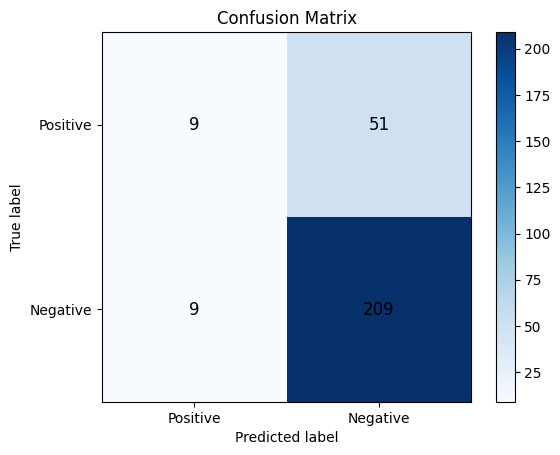

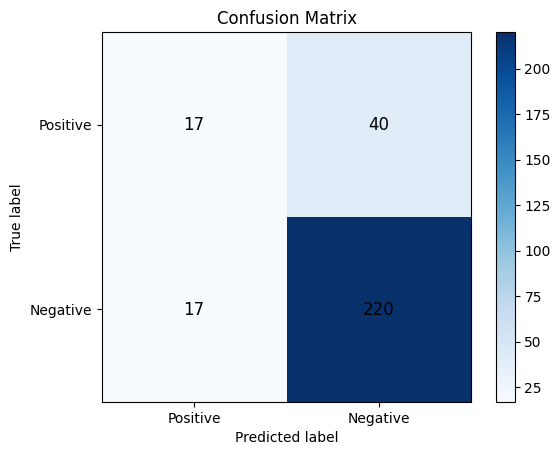

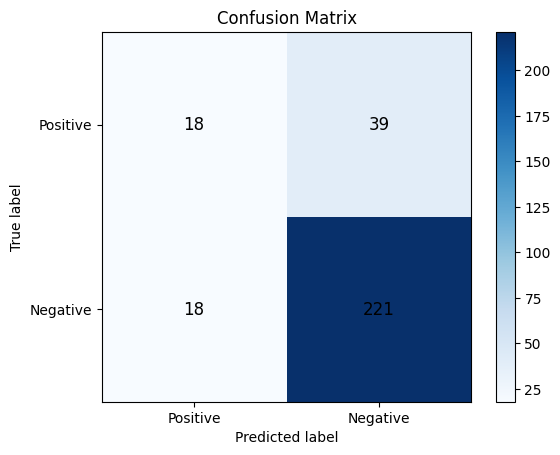

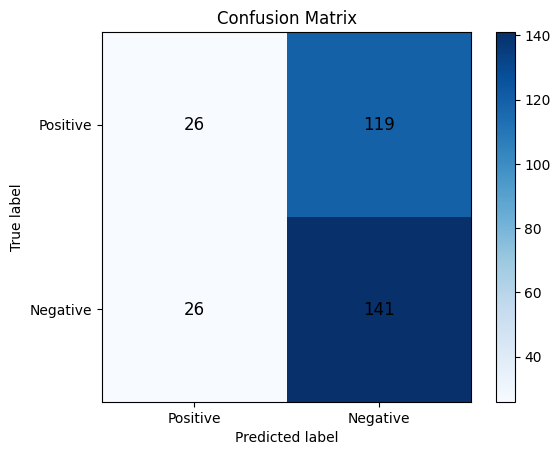

In [46]:
import matplotlib.pyplot as plt

models = {
    "Random": RandomModel(),
    "VolumeHeuristic": VolumeHeuristicModel(),
    "MoneyHeuristic": MoneyHeuristicModel(),
    "DeltaHeuristic": DeltaHeuristicModel()
}
eval = Eval()

for name, model in models.items():
    predictions = {}
    print(f"-=-=- Evaluating {name} Model")
    for event in tournaments["event"].copy().drop_duplicates():
        predictions[event] = model.predict(event)

    # print(predictions)
    cm = eval.metrics(predictions)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")

    cbar = ax.figure.colorbar(im, ax=ax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], 
                    ha="center", va="center",
                    color="black", fontsize=12)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])

plt.show()

# Predicting Market Changes